In [ ]:
"""
Project Overview:
This notebook analyzes Netflix's content catalog to uncover insights about:
- Content distribution and trends over time
- Geographic content production patterns  
- Genre popularity and rating distributions
- Content characteristics and strategy insights

Dataset: Netflix Movies and TV Shows (Kaggle)
Source: https://www.kaggle.com/datasets/shivamb/netflix-shows
"""

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import sqlite3
from datetime import datetime
import re
from collections import Counter

In [4]:
# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [5]:
def load_netflix_data(file_path):
    """
    Load Netflix dataset and perform initial validation
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully!")
        print(f"Dataset shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("File not found. Please ensure the dataset is in the correct path.")
        print("Download from: https://www.kaggle.com/datasets/shivamb/netflix-shows")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None



In [6]:
DATA_PATH = "../data/raw/netflix_titles.csv"
df = load_netflix_data(DATA_PATH)


print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
    
print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
print("\nCOLUMN INFORMATION:")
print("-"*40)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Data loaded successfully!
Dataset shape: (8807, 12)

DATASET OVERVIEW
Dataset dimensions: 8807 rows × 12 columns
Memory usage: 8.52 MB

COLUMN INFORMATION:
----------------------------------------
 1. show_id
 2. type
 3. title
 4. director
 5. cast
 6. country
 7. date_added
 8. release_year
 9. rating
10. duration
11. listed_in
12. description


In [7]:
def assess_data_quality(df):
    """
    Comprehensive data quality assessment
    """
    print("\n" + "="*60)
    print("DATA QUALITY ASSESSMENT")
    print("="*60)
    
    # Basic info
    print("\nBasic Information:")
    print(f"Total records: {len(df):,}")
    print(f"Total features: {len(df.columns)}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    # Missing values analysis
    print("\nMissing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    # Data types
    print("\nData Types:")
    print(df.dtypes)
    
    return missing_df

In [10]:
assess_data_quality(df)


DATA QUALITY ASSESSMENT

Basic Information:
Total records: 8,807
Total features: 12
Duplicate rows: 0

Missing Values Analysis:
       Column  Missing_Count  Missing_Percentage
3    director           2634           29.908028
5     country            831            9.435676
4        cast            825            9.367549
6  date_added             10            0.113546
8      rating              4            0.045418
9    duration              3            0.034064

Data Types:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


,Column,Missing_Count,Missing_Percentage
3,director,2634,29.908028
5,country,831,9.435676
4,cast,825,9.367549
6,date_added,10,0.113546
8,rating,4,0.045418
9,duration,3,0.034064
0,show_id,0,0.000000
1,type,0,0.000000
2,title,0,0.000000
7,release_year,0,0.000000


In [8]:
def clean_netflix_data(df):
    """
    Clean and preprocess Netflix data
    """
    print("\n" + "="*60)
    print("DATA CLEANING")
    print("="*60)
    
    # Create a copy for cleaning
    df_clean = df.copy()
    
    # 1. Handle date columns
    if 'date_added' in df_clean.columns:
        print("Processing date_added column...")
        df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], errors='coerce')
        df_clean['year_added'] = df_clean['date_added'].dt.year
        df_clean['month_added'] = df_clean['date_added'].dt.month
        df_clean['month_name'] = df_clean['date_added'].dt.month_name()
    
    # 2. Clean duration column
    if 'duration' in df_clean.columns:
        print("Processing duration column...")
        # Extract numeric values and units
        df_clean['duration_type'] = df_clean['duration'].str.extract('(Seasons?|min)')
        df_clean['duration_value'] = df_clean['duration'].str.extract('(\d+)').astype(float)
    
    # 3. Process categorical columns
    print("Processing categorical columns...")
    
    # Split listed_in (genres) into primary genre
    if 'listed_in' in df_clean.columns:
        df_clean['primary_genre'] = df_clean['listed_in'].str.split(',').str[0].str.strip()
        df_clean['genre_count'] = df_clean['listed_in'].str.count(',') + 1
    
    # Split country into primary country
    if 'country' in df_clean.columns:
        df_clean['primary_country'] = df_clean['country'].str.split(',').str[0].str.strip()
        df_clean['country_count'] = df_clean['country'].str.count(',') + 1
        df_clean['country_count'] = df_clean['country_count'].fillna(0)
    
    # 4. Create additional features
    print("Creating additional features...")
    
    # Content age (years since release)
    if 'release_year' in df_clean.columns:
        current_year = datetime.now().year
        df_clean['content_age'] = current_year - df_clean['release_year']
    
    # Time between release and Netflix addition
    if 'year_added' in df_clean.columns and 'release_year' in df_clean.columns:
        df_clean['years_to_netflix'] = df_clean['year_added'] - df_clean['release_year']
    
    print(f"Cleaning completed!")
    print(f"Final dataset shape: {df_clean.shape}")
    
    return df_clean

In [9]:
df_clean = clean_netflix_data(df)


DATA CLEANING
Processing date_added column...
Processing duration column...
Processing categorical columns...
Creating additional features...
Cleaning completed!
Final dataset shape: (8807, 23)


In [10]:
def analyze_genres_and_content(df):
    """
    Comprehensive genre and content analysis
    """
    print("\n" + "="*60)
    print("GENRE AND CONTENT ANALYSIS")
    print("="*60)
    
    # Create genre analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Netflix Genre and Content Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top genres overall
    top_genres = df['primary_genre'].value_counts().head(12)
    axes[0, 0].barh(range(len(top_genres)), top_genres.values)
    axes[0, 0].set_yticks(range(len(top_genres)))
    axes[0, 0].set_yticklabels(top_genres.index)
    axes[0, 0].set_title('Top 12 Genres by Content Count')
    axes[0, 0].set_xlabel('Number of Titles')
    
    # 2. Genre distribution by content type
    genre_type_crosstab = pd.crosstab(df['primary_genre'], df['type'])
    top_genres_for_comparison = genre_type_crosstab.sum(axis=1).nlargest(8).index
    genre_type_subset = genre_type_crosstab.loc[top_genres_for_comparison]
    
    genre_type_subset.plot(kind='bar', ax=axes[0, 1], color=['#E50914', '#564D4A'])
    axes[0, 1].set_title('Genre Distribution: Movies vs TV Shows')
    axes[0, 1].set_ylabel('Number of Titles')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Movie', 'TV Show'])
    
    # 3. Genre trends over time
    genre_year = df.groupby(['year_added', 'primary_genre']).size().unstack(fill_value=0)
    top_3_genres = df['primary_genre'].value_counts().head(3).index
    
    for genre in top_3_genres:
        if genre in genre_year.columns:
            axes[0, 2].plot(genre_year.index, genre_year[genre], 
                           marker='o', linewidth=2, label=genre)
    
    axes[0, 2].set_title('Top 3 Genres Trend Over Time')
    axes[0, 2].set_xlabel('Year')
    axes[0, 2].set_ylabel('Number of Titles')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Content ratings distribution
    if 'rating' in df.columns:
        rating_counts = df['rating'].value_counts()
        axes[1, 0].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Content Rating Distribution')
    
    # 5. Duration analysis
    if 'duration_value' in df.columns and 'duration_type' in df.columns:
        # Movies duration
        movies_duration = df[(df['type'] == 'Movie') & (df['duration_type'] == 'min')]['duration_value']
        axes[1, 1].hist(movies_duration.dropna(), bins=20, alpha=0.7, color='#E50914', label='Movies')
        axes[1, 1].set_title('Movie Duration Distribution')
        axes[1, 1].set_xlabel('Duration (minutes)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].axvline(movies_duration.median(), color='black', linestyle='--', 
                          label=f'Median: {movies_duration.median():.0f} min')
        axes[1, 1].legend()
    
    # 6. Release year analysis
    release_year_dist = df['release_year'].value_counts().sort_index()
    recent_years = release_year_dist[release_year_dist.index >= 2000]
    
    axes[1, 2].plot(recent_years.index, recent_years.values, 
                   marker='o', linewidth=2, color='#564D4A')
    axes[1, 2].set_title('Content by Release Year (2000+)')
    axes[1, 2].set_xlabel('Release Year')
    axes[1, 2].set_ylabel('Number of Titles')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_genres_and_content(df):
    """
    Comprehensive genre and content analysis
    """
    print("\n" + "="*60)
    print("GENRE AND CONTENT ANALYSIS")
    print("="*60)
    
    # Create genre analysis plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Netflix Genre and Content Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top genres overall
    top_genres = df['primary_genre'].value_counts().head(12)
    axes[0, 0].barh(range(len(top_genres)), top_genres.values)
    axes[0, 0].set_yticks(range(len(top_genres)))
    axes[0, 0].set_yticklabels(top_genres.index)
    axes[0, 0].set_title('Top 12 Genres by Content Count')
    axes[0, 0].set_xlabel('Number of Titles')
    
    # 2. Genre distribution by content type
    genre_type_crosstab = pd.crosstab(df['primary_genre'], df['type'])
    top_genres_for_comparison = genre_type_crosstab.sum(axis=1).nlargest(8).index
    genre_type_subset = genre_type_crosstab.loc[top_genres_for_comparison]
    
    genre_type_subset.plot(kind='bar', ax=axes[0, 1], color=['#E50914', '#564D4A'])
    axes[0, 1].set_title('Genre Distribution: Movies vs TV Shows')
    axes[0, 1].set_ylabel('Number of Titles')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Movie', 'TV Show'])
    
    # 3. Genre trends over time
    genre_year = df.groupby(['year_added', 'primary_genre']).size().unstack(fill_value=0)
    top_3_genres = df['primary_genre'].value_counts().head(3).index
    
    for genre in top_3_genres:
        if genre in genre_year.columns:
            axes[0, 2].plot(genre_year.index, genre_year[genre], 
                           marker='o', linewidth=2, label=genre)
    
    axes[0, 2].set_title('Top 3 Genres Trend Over Time')
    axes[0, 2].set_xlabel('Year')
    axes[0, 2].set_ylabel('Number of Titles')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Content ratings distribution
    if 'rating' in df.columns:
        rating_counts = df['rating'].value_counts()
        axes[1, 0].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Content Rating Distribution')
    
    # 5. Duration analysis
    if 'duration_value' in df.columns and 'duration_type' in df.columns:
        # Movies duration
        movies_duration = df[(df['type'] == 'Movie') & (df['duration_type'] == 'min')]['duration_value']
        axes[1, 1].hist(movies_duration.dropna(), bins=20, alpha=0.7, color='#E50914', label='Movies')
        axes[1, 1].set_title('Movie Duration Distribution')
        axes[1, 1].set_xlabel('Duration (minutes)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].axvline(movies_duration.median(), color='black', linestyle='--', 
                          label=f'Median: {movies_duration.median():.0f} min')
        axes[1, 1].legend()
    
    # 6. Release year analysis
    release_year_dist = df['release_year'].value_counts().sort_index()
    recent_years = release_year_dist[release_year_dist.index >= 2000]
    
    axes[1, 2].plot(recent_years.index, recent_years.values, 
                   marker='o', linewidth=2, color='#564D4A')
    axes[1, 2].set_title('Content by Release Year (2000+)')
    axes[1, 2].set_xlabel('Release Year')
    axes[1, 2].set_ylabel('Number of Titles')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


GENRE AND CONTENT ANALYSIS


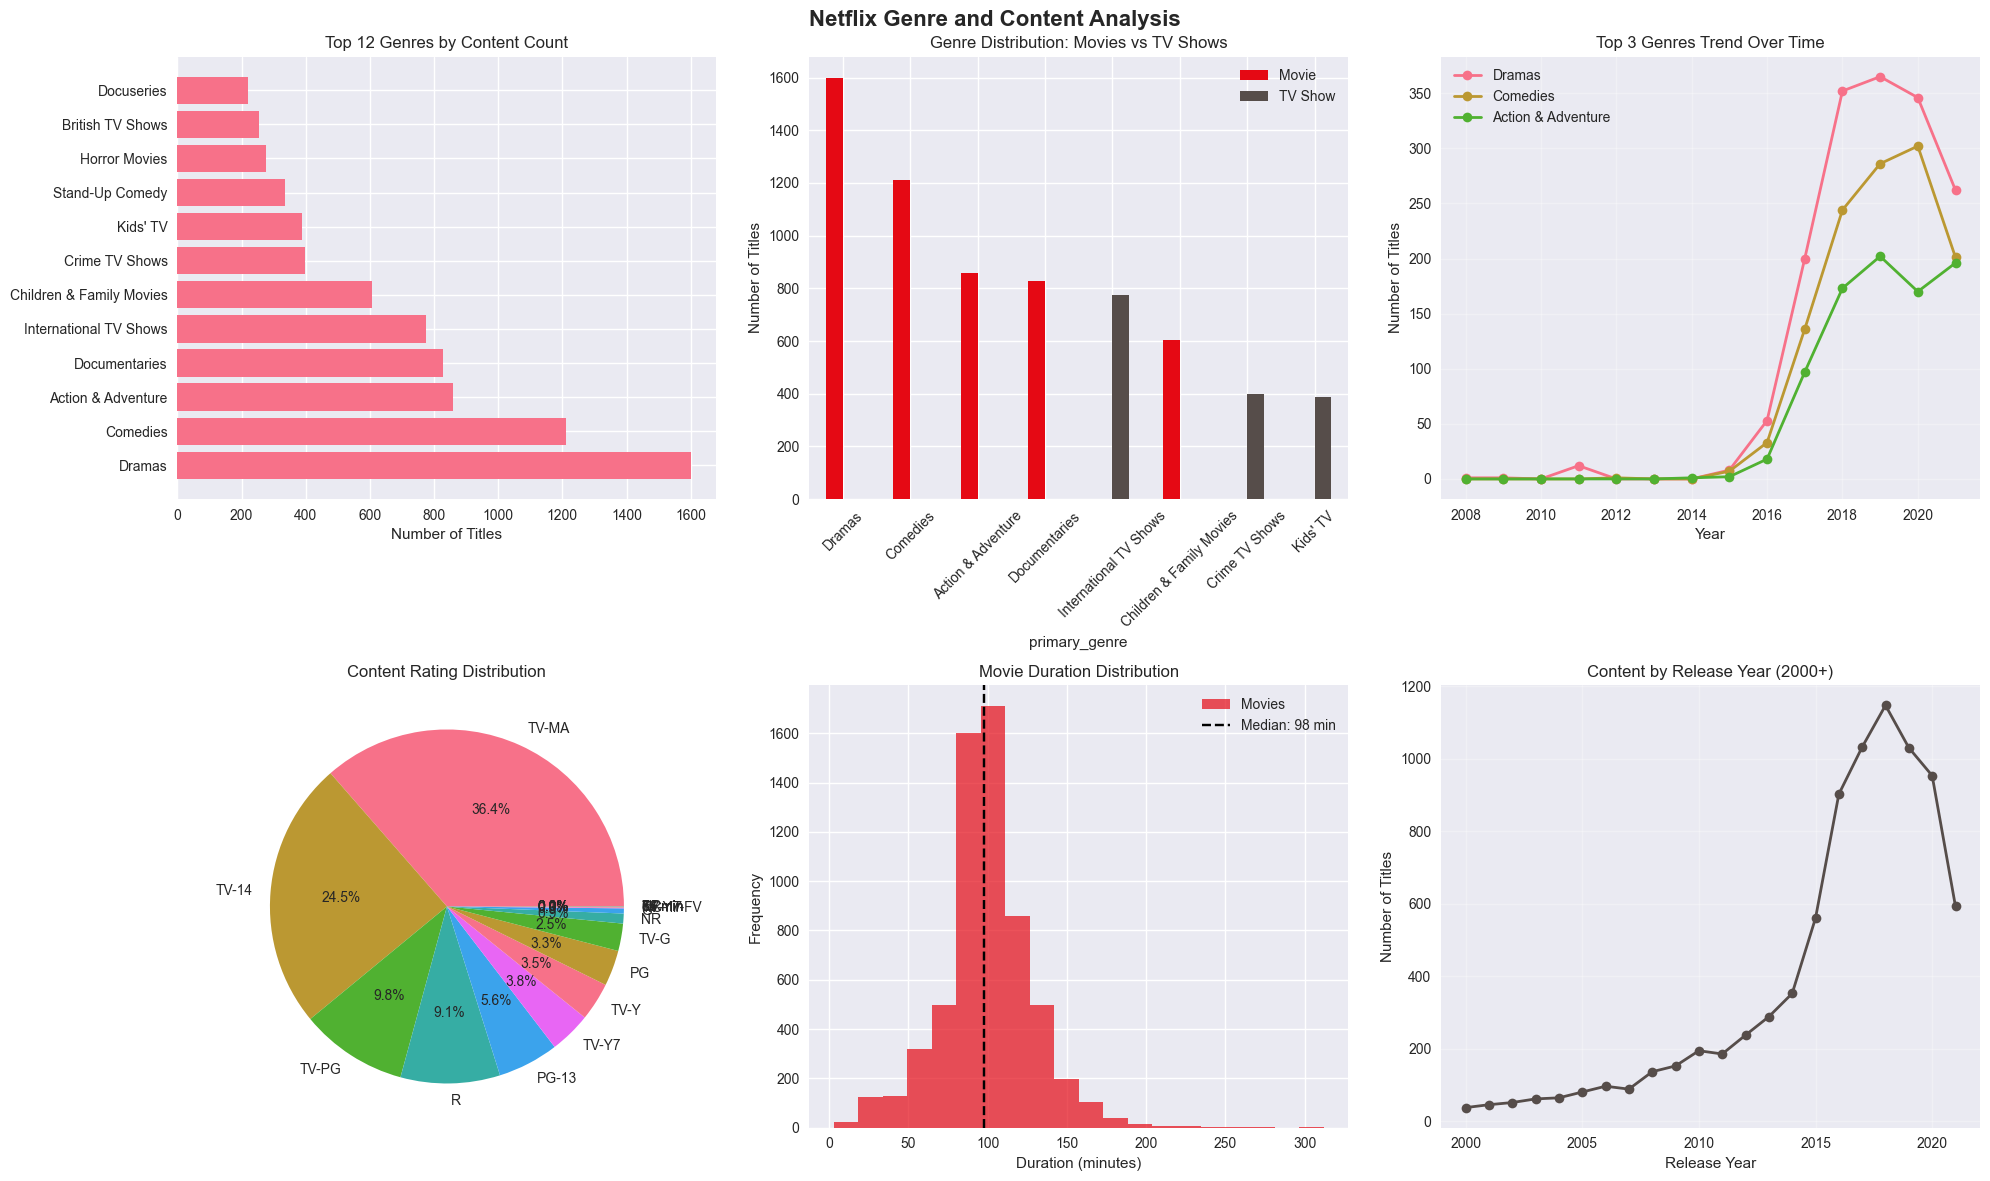

In [18]:
analyze_genres_and_content(df_clean)

In [ ]:
def generate_business_insights(df):
    """
    Generate key business insights and recommendations
    """
    print("\n" + "="*60)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*60)
    
    # Key metrics calculation
    total_content = len(df)
    movies_pct = len(df[df['type'] == 'Movie']) / total_content * 100
    tv_shows_pct = len(df[df['type'] == 'TV Show']) / total_content * 100
    
    # Content freshness
    recent_content = df[df['year_added'] >= 2018]
    growth_rate = len(recent_content) / total_content * 100
    
    # International expansion
    us_content_pct = len(df[df['primary_country'] == 'United States']) / total_content * 100
    intl_content_pct = 100 - us_content_pct
    
    print("KEY BUSINESS METRICS:")
    print("-"*40)
    print(f" Total Content Portfolio: {total_content:,} titles")
    print(f" Movies: {movies_pct:.1f}% | TV Shows: {tv_shows_pct:.1f}%")
    print(f" International Content: {intl_content_pct:.1f}%")
    print(f" Recent Growth (2018+): {growth_rate:.1f}% of total catalog")
    
    # Top performing segments
    print(f"\nTOP PERFORMING SEGMENTS:")
    print("-"*40)
    print(f" Top Genre: {df['primary_genre'].mode().iloc[0]}")
    print(f" Top Production Country: {df['primary_country'].mode().iloc[0]}")
    
    if 'rating' in df.columns:
        print(f" Most Common Rating: {df['rating'].mode().iloc[0]}")
    
    # Strategic recommendations
    print(f"\nSTRATEGIC RECOMMENDATIONS:")
    print("-"*40)
    print("1.  CONTENT STRATEGY:")
    if movies_pct > tv_shows_pct:
        print("   • Movie-heavy portfolio - consider TV show expansion")
    else:
        print("   • TV show focus aligns with binge-watching trends")
    
    print("\n2.  GLOBAL EXPANSION:")
    if intl_content_pct < 50:
        print("   • Increase international content acquisition")
        print("   • Focus on emerging markets content")
    else:
        print("   • Strong international presence - maintain diversity")
    
    print("\n3.  CONTENT CALENDAR:")
    if 'month_added' in df.columns:
        peak_month = df['month_added'].mode().iloc[0]
        month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                      7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        print(f"   • Peak addition month: {month_names[peak_month]} - optimize releases")
        print("   • Balance content drops throughout the year")
    
    print("\n4. 🎭 GENRE OPTIMIZATION:")
    top_3_genres = df['primary_genre'].value_counts().head(3)
    print("   • Top genres to prioritize:")
    for i, (genre, count) in enumerate(top_3_genres.items(), 1):
        print(f"     {i}. {genre} ({count} titles)")

In [16]:
generate_business_insights(df_clean)


BUSINESS INSIGHTS & RECOMMENDATIONS
KEY BUSINESS METRICS:
----------------------------------------
 Total Content Portfolio: 8,807 titles
 Movies: 69.6% | 📺 TV Shows: 30.4%
 International Content: 63.5%
 Recent Growth (2018+): 80.0% of total catalog

TOP PERFORMING SEGMENTS:
----------------------------------------
 Top Genre: Dramas
 Top Production Country: United States
 Most Common Rating: TV-MA

STRATEGIC RECOMMENDATIONS:
----------------------------------------
1.  CONTENT STRATEGY:
   • Movie-heavy portfolio - consider TV show expansion

2.  GLOBAL EXPANSION:
   • Strong international presence - maintain diversity

3.  CONTENT CALENDAR:
   • Peak addition month: Jul - optimize releases
   • Balance content drops throughout the year

4. 🎭 GENRE OPTIMIZATION:
   • Top genres to prioritize:
     1. Dramas (1600 titles)
     2. Comedies (1210 titles)
     3. Action & Adventure (859 titles)


In [17]:
def create_overview_analysis(df):
    """
    Create overview visualizations and statistics
    """
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS - OVERVIEW")
    print("="*60)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Netflix Content Overview Analysis', fontsize=16, fontweight='bold')
    
    # 1. Content Type Distribution
    type_counts = df['type'].value_counts()
    axes[0, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=['#E50914', '#564D4A'])
    axes[0, 0].set_title('Content Type Distribution')
    
    # 2. Top Countries by Content Count
    if 'primary_country' in df.columns:
        top_countries = df['primary_country'].value_counts().head(10)
        axes[0, 1].barh(range(len(top_countries)), top_countries.values)
        axes[0, 1].set_yticks(range(len(top_countries)))
        axes[0, 1].set_yticklabels(top_countries.index)
        axes[0, 1].set_title('Top 10 Countries by Content Production')
        axes[0, 1].set_xlabel('Number of Titles')
    
    # 3. Content Addition Trend by Year
    if 'year_added' in df.columns:
        yearly_additions = df.groupby('year_added').size()
        axes[1, 0].plot(yearly_additions.index, yearly_additions.values, 
                       marker='o', linewidth=2, markersize=6, color='#E50914')
        axes[1, 0].set_title('Netflix Content Additions Over Time')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Number of Titles Added')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Top Genres
    if 'primary_genre' in df.columns:
        top_genres = df['primary_genre'].value_counts().head(8)
        axes[1, 1].bar(range(len(top_genres)), top_genres.values, color='#564D4A')
        axes[1, 1].set_xticks(range(len(top_genres)))
        axes[1, 1].set_xticklabels(top_genres.index, rotation=45, ha='right')
        axes[1, 1].set_title('Top 8 Content Genres')
        axes[1, 1].set_ylabel('Number of Titles')
    
    plt.tight_layout()
    plt.show()


KEY STATISTICS:
----------------------------------------
Total Content: 8,807 titles
Movies: 6,131 (69.6%)
TV Shows: 2,676 (30.4%)

EXPLORATORY DATA ANALYSIS - OVERVIEW


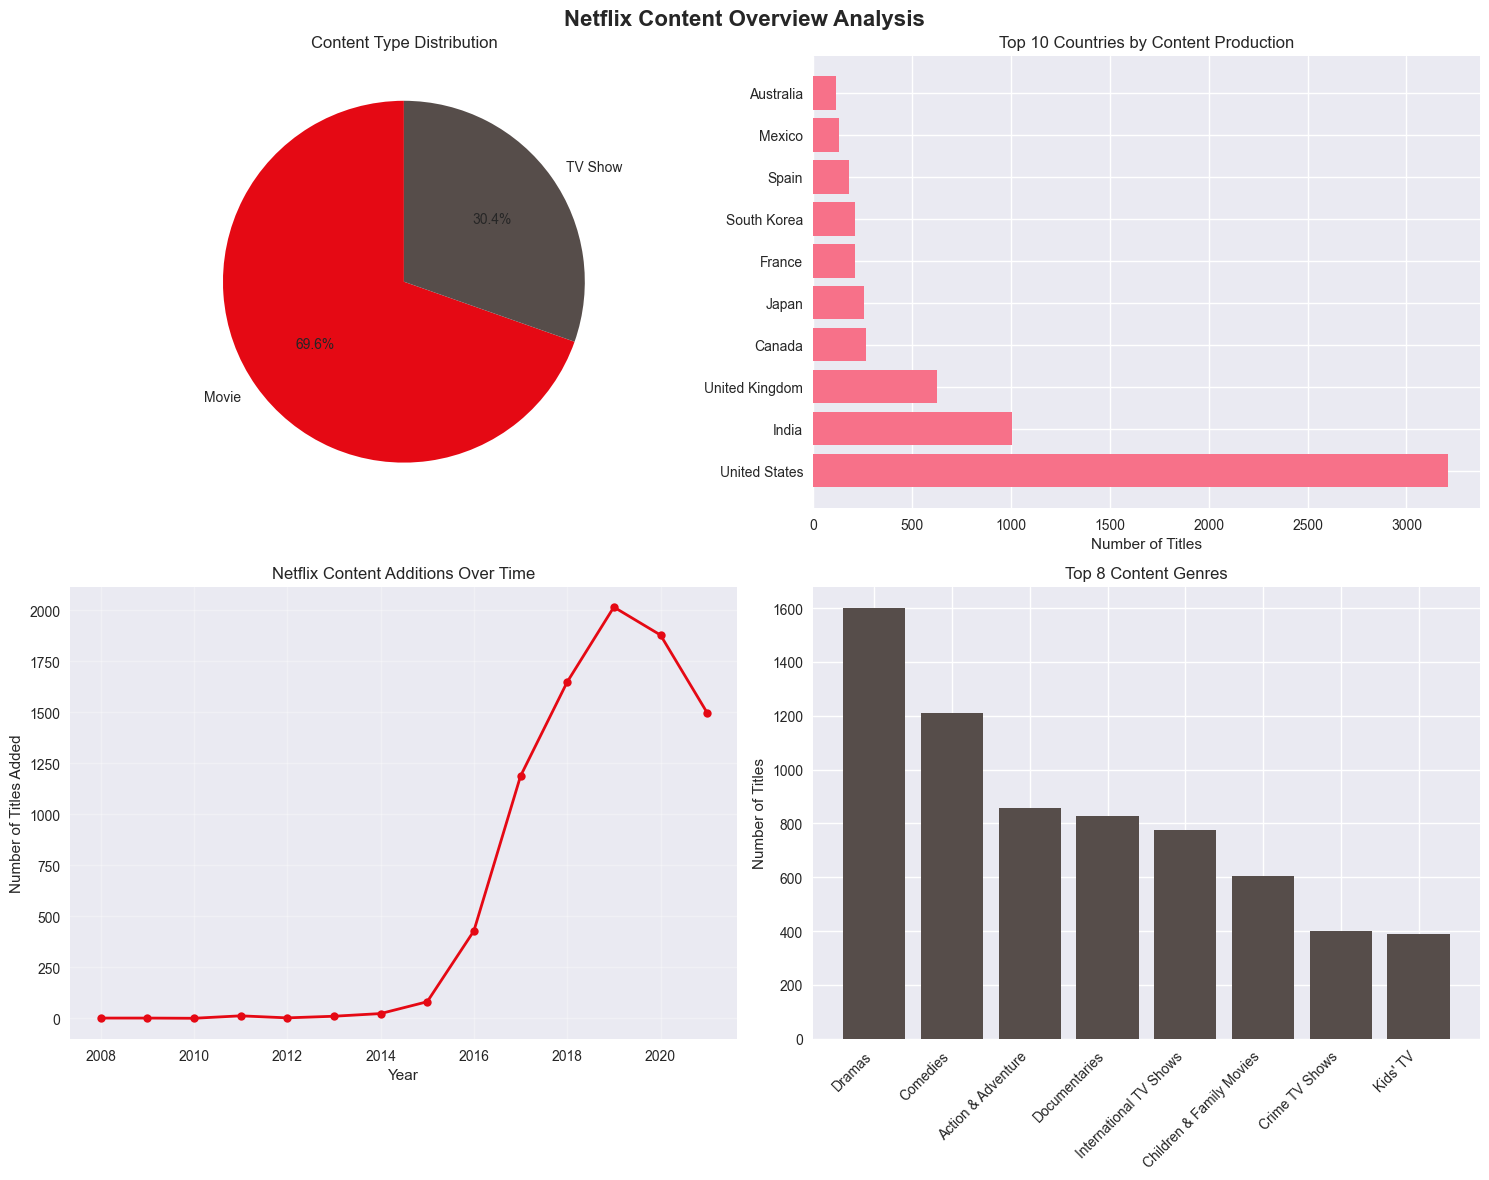

In [23]:
print("\nKEY STATISTICS:")
print("-"*40)
print(f"Total Content: {len(df):,} titles")
print(f"Movies: {len(df[df['type'] == 'Movie']):,} ({len(df[df['type'] == 'Movie'])/len(df)*100:.1f}%)")
print(f"TV Shows: {len(df[df['type'] == 'TV Show']):,} ({len(df[df['type'] == 'TV Show'])/len(df)*100:.1f}%)")
    
if 'year_added' in df.columns:
    print(f"Content span: {df['year_added'].min():.0f} - {df['year_added'].max():.0f}")
    print(f"Peak addition year: {df['year_added'].mode().iloc[0]:.0f}")
    
if 'primary_country' in df.columns:
    print(f"Countries represented: {df['primary_country'].nunique()}")
    print(f"Top producing country: {df['primary_country'].mode().iloc[0]}")

if df_clean is not None:
    create_overview_analysis(df_clean)

In [19]:
def export_analysis_data(df):
    """
    Export cleaned data
    """
    
    try:
        df.to_csv('../data/processed/netflix_final_clean.csv', index=False)
        print("Done")
    except:
        print("Export path not available")
    

In [21]:
export_analysis_data(df_clean)

Done
